In [1]:
import numpy as np
import pandas as pd
import rebound
from celmech import Andoyer, AndoyerHamiltonian
import dask.dataframe as dd
from celmech import *
from celmech.resonances import resonant_period_ratios
from celmech.andoyer import get_num_fixed_points
from collections import OrderedDict
%matplotlib inline

In [2]:
respath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/stabilitydataset/data/resonant/'
sapath = 'simulation_archives/runs/sa'

# Use this first simulation as a testing example

In [3]:
runstring = '0000000.bin'
snapshot = 0
sa = rebound.SimulationArchive(respath+sapath+runstring)
sim = sa[snapshot]

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


In [4]:
print('P2/P1', sim.particles[2].P/sim.particles[1].P)
print('P3/P2', sim.particles[3].P/sim.particles[2].P)

P2/P1 1.8445744838304716
P3/P2 1.0916975177402766


The outer two planets are close to 12:11 (1.0909 period ratio) resonance, so set the indices to the outer two:

In [5]:
i1 = 2
i2 = 3

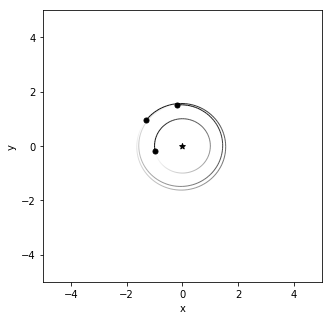

In [6]:
fig = rebound.OrbitPlot(sim, lim=5)

# There's a first transformation I forgot to mention to 'averaged variables' 

It essentially tries to take away the effects of conjunctions where an inner planet overtakes an outer one, where the orbital elements will jump up and then back down. This is not really necessary if you start far from a conjunction, but if you're trying to get resonant variables at a snapshot that's undergoing a conjunction, then the orbital elements you'd use would not be representative of the whole orbit. These are small corrections that look a lot like forces and I think make sense in a graphnet. For each pair of planets you calculate equal and opposite corrections on each particle's semimajor axis, which is weighted by the other's mass. 

In [7]:
poinc = Poincare.from_Simulation(sim)

# Resonance Strengths

This function calculates resonance strengths for a j:j-k resonance given masses (m), mean motions = 2pi/orbital period (n), eccentricities (e) and longitude of pericenter (pomega) for each body

In [8]:
def calc_res_strength(j, k, m1, m2, n1, n2, e1, e2, pomega1, pomega2):
    Z = np.sqrt((e1*np.cos(pomega1) - e2*np.cos(pomega2))**2 + (e1*np.sin(pomega1) - e2*np.sin(pomega2))**2)
    #print(Z)
    return np.abs(np.sqrt(m1+m2)*Z**(k/2.)/(j*n2 - (j-k)*n1))

# Finding the Strong Resonances

This function in celmech takes a min period ratio, max period ratio and a maximum order resonance to consider (we want to set this to two). It then returns a list of all the resonances that lie in that period range. The period ratio should be less than one, i.e. Period(inner)/P(outer). You'd look through all the pairs (or adjacent pairs), but here we've already figured out which particles indices are closest to resonance

In [9]:
delta = 0.03
Pratio = sim.particles[i1].P/sim.particles[i2].P
minperiodratio = max(Pratio-delta, 0.)
maxperiodratio = min(Pratio+delta, 0.999) # too many resonances close to 1
res = resonant_period_ratios(minperiodratio,maxperiodratio, order=2)

In [10]:
res

array([[ 8,  9],
       [17, 19],
       [ 9, 10],
       [19, 21],
       [10, 11],
       [21, 23],
       [11, 12],
       [23, 25],
       [12, 13],
       [25, 27],
       [13, 14],
       [27, 29],
       [14, 15],
       [29, 31],
       [15, 16],
       [31, 33],
       [16, 17],
       [33, 35],
       [17, 18],
       [35, 37]])

In [11]:
ps = poinc.particles
res = resonant_period_ratios(Pratio-delta,Pratio+delta, order=2)
strengths = np.zeros((len(res), 3))
for i, (a, b) in enumerate(res):
    j = b
    k = b-a
    strengths[i] = [j, k, calc_res_strength(j, k, ps[i1].m, ps[i2].m, ps[i1].n, ps[i2].n, ps[i1].e, ps[i2].e, ps[i1].pomega, ps[i2].pomega)]

sortedstrengths = strengths[strengths[:,2].argsort()][::-1]
    
for res in sortedstrengths:
    print(int(res[0]), int(res[1]), res[2])

12 1 0.04824427381301188
11 1 0.0023070135609413005
13 1 0.0021056332109779573
10 1 0.0011265707951570027
14 1 0.0010763043905751453
9 1 0.0007452463510067455
15 1 0.0007229121907158289
16 1 0.0005442228582438629
17 1 0.00043636277066132716
23 2 0.0004265723762116975
18 1 0.0003641846421540085
25 2 0.000355215345756078
21 2 0.00013326705829331707
27 2 0.00012539726720066434
19 2 7.896903347674869e-05
29 2 7.613758765659086e-05
31 2 5.466398904442725e-05
33 2 4.263839439538971e-05
35 2 3.494975669386216e-05
37 2 2.9610359439953797e-05


# Max strength is for the j=12, k=1 = 12:11 (j:j-k) resonance as expected

In [12]:
strongres = sortedstrengths[0]
print(strongres)

[12.          1.          0.04824427]


# Compare the simplified resonance model evolution (orange) to the Nbody one in resonance variables

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

j = int(strongres[0])
k = int(strongres[1])

andvars = Andoyer.from_Simulation(sim=sim, j=j, k=k, i1=i1, i2=i2)
H = AndoyerHamiltonian(andvars)
tmax=100*andvars.params['tau']
Nout = 1000
times = np.linspace(0, tmax, Nout)

Z, phi = np.zeros(Nout), np.zeros(Nout)
NZ, Nphi = np.zeros(Nout), np.zeros(Nout)

for i, time in enumerate(times):
    H.integrate(time)
    sim.integrate(time)
    Z[i] = H.state.Z
    phi[i] = H.state.phi
    NZ[i] = Andoyer.from_Simulation(sim=sim, j=j, k=k, i1=i1, i2=i2).Z
    Nphi[i] = Andoyer.from_Simulation(sim=sim, j=j, k=k, i1=i1, i2=i2).phi

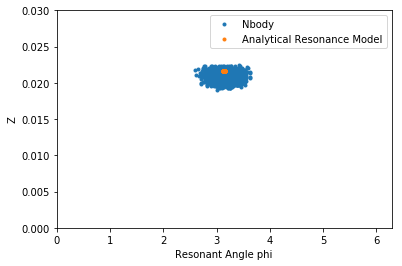

In [14]:
fig, ax = plt.subplots()
ax.plot(Nphi, NZ, '.', label='Nbody')
ax.plot(phi, Z, '.', label='Analytical Resonance Model')
ax.set_xlim([0, 2*np.pi])
ax.set_ylim([0, 0.03])
ax.set_xlabel('Resonant Angle phi')
ax.set_ylabel('Z')
ax.legend()

In [15]:
def initrow(sim, runstring, snapshot):
    row = OrderedDict()
    row['runstring'] = runstring
    row['snapshot'] = snapshot
    ps = sim.particles
    row['crossing'] = 1 if (ps[1].a/ps[2].a >= 1. or ps[2].a/ps[3].a >= 1.) else 0
    return row

def transform_to_res(sim, runstring, snapshot, j, k, i1, i2):
    row = initrow(sim, runstring, snapshot)
    if row['crossing'] == True:
        return set_row_nan(row)
    
    pvars = Poincare.from_Simulation(sim) # averaging step only makes sense if not crossing
    a10 = sim.particles[i1].a
    ps = pvars.particles
    avars = Andoyer.from_Poincare(pvars, j=j, k=k, a10=a10, i1=i1, i2=i2)
    row['i1'] = i1
    row['i2'] = i2
    row['j'] = j
    row['k'] = k
    row['m1'] = ps[i1].m
    row['m2'] = ps[i2].m
    row['n1'] = ps[i1].n
    row['n2'] = ps[i2].n
    row['a1cosl1'] = ps[i1].a*np.cos(ps[i1].l)
    row['a1sinl1'] = ps[i1].a*np.sin(ps[i1].l)
    row['a2cosl2'] = ps[i2].a*np.cos(ps[i2].l)
    row['a2sinl2'] = ps[i2].a*np.sin(ps[i2].l)
    row['k1'] = ps[i1].e*np.cos(ps[i1].pomega)
    row['h1'] = ps[i1].e*np.sin(ps[i1].pomega)
    row['k2'] = ps[i2].e*np.cos(ps[i2].pomega)
    row['h2'] = ps[i2].e*np.sin(ps[i2].pomega)
    
    row['Zcosphi'] = avars.Z*np.cos(avars.phi)
    row['Zsinphi'] = avars.Z*np.sin(avars.phi)
    row['Zcomcosphicom'] = avars.Zcom*np.cos(avars.phiZcom)
    row['Zcomsinphicom'] = avars.Zcom*np.sin(avars.phiZcom)
    row['Zstarcostheta'] = avars.Zstar*np.cos(avars.theta)
    row['Zstarsintheta'] = avars.Zstar*np.sin(avars.theta)
    row['dKprimecostheta1'] = avars.dKprime*np.cos(avars.theta1)
    row['dKprimesintheta1'] = avars.dKprime*np.sin(avars.theta1)
    row['alpha'] = ps[i1].a/ps[i2].a
    row['res_strength'] = np.abs(np.sqrt(ps[i1].m + ps[i2].m)*avars.Z**(k/2.)/(j*ps[i2].n - (j-k)*ps[i1].n))
    row['Phiprime'] = avars.Phiprime
    row['Zstar'] = avars.Zstar
    row['Zstarnonres'] = avars.Zstar_nonres
    row['Zstarunstable'] = avars.Zstar_unstable
    row['Zsep_inner'] = avars.Zsep_inner
    row['Zsep_outer'] = avars.Zsep_outer
    row['tlib'] = avars.tlib
    row['num_fixed_points'] = get_num_fixed_points(k, row['Phiprime'])
    
    return row

def set_row_nan(row):
    row['i1'] = 0
    row['i2'] = 0
    row['j'] = 0
    row['k'] = 0
    row['m1'] = np.nan
    row['m2'] = np.nan
    row['n1'] = np.nan
    row['n2'] = np.nan
    row['a1cosl1'] = np.nan
    row['a1sinl1'] = np.nan
    row['a2cosl2'] = np.nan
    row['a2sinl2'] = np.nan
    row['k1'] = np.nan
    row['h1'] = np.nan
    row['k2'] = np.nan
    row['h2'] = np.nan
    
    row['Zcosphi'] = np.nan
    row['Zsinphi'] = np.nan
    row['Zcomcosphicom'] = np.nan
    row['Zcomsinphicom'] = np.nan
    row['Zstarcostheta'] = np.nan
    row['Zstarsintheta'] = np.nan
    row['dKprimecostheta1'] = np.nan
    row['dKprimesintheta1'] = np.nan
    row['alpha'] = np.nan
    row['res_strength'] = np.nan
    row['Phiprime'] = np.nan
    row['Zstar'] = np.nan
    row['Zstarnonres'] = np.nan
    row['Zstarunstable'] = np.nan
    row['Zsep_inner'] = np.nan
    row['Zsep_outer'] = np.nan
    row['tlib'] = np.nan
    row['num_fixed_points'] = 0
    
    return row

# Test function

Zcosphi = -0.02 and Zsinphi = 0 as expected from above

In [16]:
sa = rebound.SimulationArchive(respath+sapath+runstring)
sim = sa[0]
testres = transform_to_res(sim, runstring, 0, 12, 1, 2, 3)
testres

OrderedDict([('runstring', '0000000.bin'),
             ('snapshot', 0),
             ('crossing', 0),
             ('i1', 2),
             ('i2', 3),
             ('j', 12),
             ('k', 1),
             ('m1', 1.24440162459276e-05),
             ('m2', 2.531701779802877e-07),
             ('n1', 3.406264592525528),
             ('n2', 3.1213255608381356),
             ('a1cosl1', -0.06910187220909886),
             ('a1sinl1', 1.5024846718853209),
             ('a2cosl2', -1.2118409747143202),
             ('a2sinl2', 1.0359132524808026),
             ('k1', 0.04136978390960896),
             ('h1', -0.00716342671032666),
             ('k2', 0.027415521869871017),
             ('h2', 0.02051528093765677),
             ('Zcosphi', -0.02164628281701637),
             ('Zsinphi', -0.0002824594901328155),
             ('Zcomcosphicom', 0.04113885730144521),
             ('Zcomsinphicom', -0.006626484526596268),
             ('Zstarcostheta', 0.009057544447251799),
             ('Zs

# runres takes a simulation and pair of particles i1 and i2 and returns list of rows for each resonance found by resonant_period_ratios routine, with input orbital elements and output resonance variables

In [17]:
def runres(sim, runstring, snapshot, i1, i2, maxres):
    try:
        pvars = Poincare.from_Simulation(sim)
    except: # at least one particle on a parabolic or hyperbolic orbit
        return []
    ps = pvars.particles
    delta = 0.03
    Pratio = sim.particles[i1].P/sim.particles[i2].P
    minperiodratio = max(Pratio-delta, 0.)
    maxperiodratio = min(Pratio+delta, 0.999) # too many resonances close to 1
    res = resonant_period_ratios(minperiodratio,maxperiodratio, order=2)
    strengths = np.zeros((len(res), 3))
    for i, (a, b) in enumerate(res):
        j = b
        k = b-a
        strengths[i] = [j, k, calc_res_strength(j, k, ps[i1].m, ps[i2].m, ps[i1].n, ps[i2].n, ps[i1].e, ps[i2].e, ps[i1].pomega, ps[i2].pomega)]

    sortedstrengths = strengths[strengths[:,2].argsort()][::-1]
    
    result = []
    for i, res in enumerate(sortedstrengths):
        if i >= maxres:
            break
        j=int(res[0])
        k=int(res[1])
        #print(snapshot, j, k, i1, i2)
        result.append(transform_to_res(sim, runstring, snapshot, j, k, i1, i2))
        
    return result

# Takes a row in the dataframe of runstrings, loads the appropriate simulationarchive returns a dataframe of resonance transformation examples for all the nearby resonances for every adjacent pair of planets, for each snapshot in the simulationarchive. Takes a max number of snapshots to output for each simulationarchive and max number of resonances to output (orders them from strongest to weakest) for each snapshot

In [18]:
def populate(row, maxsnapshots=10, maxres=10):
    runstring = row['runstring']
    print(runstring)
    sa = rebound.SimulationArchive(respath+sapath+runstring)
    # get a list of examples for all different nearby resonances with runres, for each combination of a) snapshots in the archive and b) pairs of adjacent particles
    maxsnapshots = min(maxsnapshots, len(sa))
    combinations = [runres(sa[snapshot], runstring, snapshot, i1, i1+1, maxres) for snapshot in range(maxsnapshots) for i1 in range(1,3)]
    # flatten the list of resonances for each combination into a single list of examples
    rows = [resonance for case in combinations for resonance in case]
    return pd.DataFrame(data=rows)

# Do 10 res per snapshot, and 10 snapshots per archive. Not all simulationarchives will have the max of each, so this is an upper limit. For two pairs of adjacent planets, max for 10,000 res systems is 2 million

In [19]:
maxres = 10
maxsnapshots = 10
df = pd.read_csv(respath+'resonant.csv', index_col=0)

In [20]:
%%time
data = pd.concat([populate(row, maxsnapshots, maxres) for _, row in df.iterrows()])

0000000.bin
0000001.bin


/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/andoyer.py:74: UserWarning: k=1 resonance does not have a non-resonant fixed point for Phiprime < 1
  warnings.warn("k=1 resonance does not have a non-resonant fixed point for Phiprime < 1")
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/andoyer.py:52: UserWarning: k=1 resonance has no unstable fixed point for Phiprime < 1
  warnings.warn("k=1 resonance has no unstable fixed point for Phiprime < 1")
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/andoyer.py:98: UserWarning: k=1 resonance has no separatrix for Phiprime < 1
  warnings.warn("k=1 resonance has no separatrix for Phiprime < 1")
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/andoyer.py:263: RuntimeWarning: invalid value encountered in double_scalars
  return 2*(2*self.B)**(self.params['k']/4.)/self.params['tau']


0000002.bin
0000003.bin


/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/andoyer.py:79: UserWarning: k=2 resonance has no non-resonant fixed point for Phiprime < 2/3
  warnings.warn("k=2 resonance has no non-resonant fixed point for Phiprime < 2/3")
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/andoyer.py:57: UserWarning: k=2 resonance has no unstable fixed point for Phiprime < -2/3
  warnings.warn("k=2 resonance has no unstable fixed point for Phiprime < -2/3")
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/andoyer.py:106: UserWarning: k=2 resonance has no separatrix for Phiprime < -2/3
  warnings.warn("k=2 resonance has no separatrix for Phiprime < -2/3")


0000004.bin
0000005.bin
0000006.bin
0000007.bin
0000008.bin
0000009.bin
0000010.bin
0000011.bin
0000012.bin
0000013.bin
0000014.bin
0000015.bin
0000016.bin
0000017.bin
0000018.bin
0000019.bin
0000020.bin
0000021.bin
0000022.bin
0000023.bin
0000024.bin
0000025.bin
0000026.bin
0000027.bin
0000028.bin
0000029.bin
0000030.bin
0000031.bin
0000032.bin
0000033.bin
0000034.bin
0000035.bin
0000036.bin
0000037.bin
0000038.bin
0000039.bin
0000040.bin
0000041.bin
0000042.bin
0000043.bin
0000044.bin
0000045.bin
0000046.bin
0000047.bin
0000048.bin
0000049.bin
0000050.bin
0000051.bin
0000052.bin
0000053.bin
0000054.bin
0000055.bin
0000056.bin
0000057.bin
0000058.bin
0000059.bin
0000060.bin
0000061.bin
0000062.bin
0000063.bin
0000064.bin
0000065.bin
0000066.bin
0000067.bin
0000068.bin
0000069.bin
0000070.bin
0000071.bin
0000072.bin
0000073.bin
0000074.bin
0000075.bin
0000076.bin
0000077.bin
0000078.bin
0000079.bin
0000080.bin
0000081.bin
0000082.bin
0000083.bin
0000084.bin
0000085.bin
0000086.bin
0000

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/resonances.py:26: RuntimeWarning: divide by zero encountered in true_divide
  msk = np.array( list(map( lambda x: min_per_ratio < x[0]/float(x[1]) < max_per_ratio , res_ratios )) )


0000111.bin
0000112.bin
0000113.bin
0000114.bin
0000115.bin
0000116.bin
0000117.bin
0000118.bin
0000119.bin
0000120.bin
0000121.bin
0000122.bin
0000123.bin
0000124.bin
0000125.bin
0000126.bin
0000127.bin
0000128.bin
0000129.bin
0000130.bin
0000131.bin
0000132.bin
0000133.bin
0000134.bin
0000135.bin
0000136.bin
0000137.bin
0000138.bin
0000139.bin
0000140.bin
0000141.bin
0000142.bin
0000143.bin
0000144.bin
0000145.bin
0000146.bin
0000147.bin
0000148.bin
0000149.bin
0000150.bin
0000151.bin
0000152.bin
0000153.bin
0000154.bin
0000155.bin
0000156.bin
0000157.bin
0000158.bin
0000159.bin
0000160.bin
0000161.bin
0000162.bin
0000163.bin
0000164.bin
0000165.bin
0000166.bin
0000167.bin
0000168.bin
0000169.bin
0000170.bin
0000171.bin
0000172.bin
0000173.bin
0000174.bin
0000175.bin
0000176.bin
0000177.bin
0000178.bin
0000179.bin
0000180.bin
0000181.bin
0000182.bin
0000183.bin
0000184.bin
0000185.bin
0000186.bin
0000187.bin
0000188.bin
0000189.bin
0000190.bin
0000191.bin
0000192.bin
0000193.bin
0000

0000795.bin
0000796.bin
0000797.bin
0000798.bin
0000799.bin
0000800.bin
0000801.bin
0000802.bin
0000803.bin
0000804.bin
0000805.bin
0000806.bin
0000807.bin
0000808.bin
0000809.bin
0000810.bin
0000811.bin
0000812.bin
0000813.bin
0000814.bin
0000815.bin
0000816.bin
0000817.bin
0000818.bin
0000819.bin
0000820.bin
0000821.bin
0000822.bin
0000823.bin
0000824.bin
0000825.bin
0000826.bin
0000827.bin
0000828.bin
0000829.bin
0000830.bin
0000831.bin
0000832.bin
0000833.bin
0000834.bin
0000835.bin
0000836.bin
0000837.bin
0000838.bin
0000839.bin
0000840.bin
0000841.bin
0000842.bin
0000843.bin
0000844.bin
0000845.bin
0000846.bin
0000847.bin
0000848.bin
0000849.bin
0000850.bin
0000851.bin
0000852.bin
0000853.bin
0000854.bin
0000855.bin
0000856.bin
0000857.bin
0000858.bin
0000859.bin
0000860.bin
0000861.bin
0000862.bin
0000863.bin
0000864.bin
0000865.bin
0000866.bin
0000867.bin
0000868.bin
0000869.bin
0000870.bin
0000871.bin
0000872.bin
0000873.bin
0000874.bin
0000875.bin
0000876.bin
0000877.bin
0000

0001478.bin
0001479.bin
0001480.bin
0001481.bin
0001482.bin
0001483.bin
0001484.bin
0001485.bin
0001486.bin
0001487.bin
0001488.bin
0001489.bin
0001490.bin
0001491.bin
0001492.bin
0001493.bin
0001494.bin
0001495.bin
0001496.bin
0001497.bin
0001498.bin
0001499.bin
0001500.bin
0001501.bin
0001502.bin
0001503.bin
0001504.bin
0001505.bin
0001506.bin
0001507.bin
0001508.bin
0001509.bin
0001510.bin
0001511.bin
0001512.bin
0001513.bin
0001514.bin
0001515.bin
0001516.bin
0001517.bin
0001518.bin
0001519.bin
0001520.bin
0001521.bin
0001522.bin
0001523.bin
0001524.bin
0001525.bin
0001526.bin
0001527.bin
0001528.bin
0001529.bin
0001530.bin
0001531.bin
0001532.bin
0001533.bin
0001534.bin
0001535.bin
0001536.bin
0001537.bin
0001538.bin
0001539.bin
0001540.bin
0001541.bin
0001542.bin
0001543.bin
0001544.bin
0001545.bin
0001546.bin
0001547.bin
0001548.bin
0001549.bin
0001550.bin
0001551.bin
0001552.bin
0001553.bin
0001554.bin
0001555.bin
0001556.bin
0001557.bin
0001558.bin
0001559.bin
0001560.bin
0001

0002162.bin
0002163.bin
0002164.bin
0002165.bin
0002166.bin
0002167.bin
0002168.bin
0002169.bin
0002170.bin
0002171.bin
0002172.bin
0002173.bin
0002174.bin
0002175.bin
0002176.bin
0002177.bin
0002178.bin
0002179.bin
0002180.bin
0002181.bin
0002182.bin
0002183.bin
0002184.bin
0002185.bin
0002186.bin
0002187.bin
0002188.bin
0002189.bin
0002190.bin
0002191.bin
0002192.bin
0002193.bin
0002194.bin
0002195.bin
0002196.bin
0002197.bin
0002198.bin
0002199.bin
0002200.bin
0002201.bin
0002202.bin
0002203.bin
0002204.bin
0002205.bin
0002206.bin
0002207.bin
0002208.bin
0002209.bin
0002210.bin
0002211.bin
0002212.bin
0002213.bin
0002214.bin
0002215.bin
0002216.bin
0002217.bin
0002218.bin
0002219.bin
0002220.bin
0002221.bin
0002222.bin
0002223.bin
0002224.bin
0002225.bin
0002226.bin
0002227.bin
0002228.bin
0002229.bin
0002230.bin
0002231.bin
0002232.bin
0002233.bin
0002234.bin
0002235.bin
0002236.bin
0002237.bin
0002238.bin
0002239.bin
0002240.bin
0002241.bin
0002242.bin
0002243.bin
0002244.bin
0002

0002846.bin
0002847.bin
0002848.bin
0002849.bin
0002850.bin
0002851.bin
0002852.bin
0002853.bin
0002854.bin
0002855.bin
0002856.bin
0002857.bin
0002858.bin
0002859.bin
0002860.bin
0002861.bin
0002862.bin
0002863.bin
0002864.bin
0002865.bin
0002866.bin
0002867.bin
0002868.bin
0002869.bin
0002870.bin
0002871.bin
0002872.bin
0002873.bin
0002874.bin
0002875.bin
0002876.bin
0002877.bin
0002878.bin
0002879.bin
0002880.bin
0002881.bin
0002882.bin
0002883.bin
0002884.bin
0002885.bin
0002886.bin
0002887.bin
0002888.bin
0002889.bin
0002890.bin
0002891.bin
0002892.bin
0002893.bin
0002894.bin
0002895.bin
0002896.bin
0002897.bin
0002898.bin
0002899.bin
0002900.bin
0002901.bin
0002902.bin
0002903.bin
0002904.bin
0002905.bin
0002906.bin
0002907.bin
0002908.bin
0002909.bin
0002910.bin
0002911.bin
0002912.bin
0002913.bin
0002914.bin
0002915.bin
0002916.bin
0002917.bin
0002918.bin
0002919.bin
0002920.bin
0002921.bin
0002922.bin
0002923.bin
0002924.bin
0002925.bin
0002926.bin
0002927.bin
0002928.bin
0002

0003530.bin
0003531.bin
0003532.bin
0003533.bin
0003534.bin
0003535.bin
0003536.bin
0003537.bin
0003538.bin
0003539.bin
0003540.bin
0003541.bin
0003542.bin
0003543.bin
0003544.bin
0003545.bin
0003546.bin
0003547.bin
0003548.bin
0003549.bin
0003550.bin
0003551.bin
0003552.bin
0003553.bin
0003554.bin
0003555.bin
0003556.bin
0003557.bin
0003558.bin
0003559.bin
0003560.bin
0003561.bin
0003562.bin
0003563.bin
0003564.bin
0003565.bin
0003566.bin
0003567.bin
0003568.bin
0003569.bin
0003570.bin
0003571.bin
0003572.bin
0003573.bin
0003574.bin
0003575.bin
0003576.bin
0003577.bin
0003578.bin
0003579.bin
0003580.bin
0003581.bin
0003582.bin
0003583.bin
0003584.bin
0003585.bin
0003586.bin
0003587.bin
0003588.bin
0003589.bin
0003590.bin
0003591.bin
0003592.bin
0003593.bin
0003594.bin
0003595.bin
0003596.bin
0003597.bin
0003598.bin
0003599.bin
0003600.bin
0003601.bin
0003602.bin
0003603.bin
0003604.bin
0003605.bin
0003606.bin
0003607.bin
0003608.bin
0003609.bin
0003610.bin
0003611.bin
0003612.bin
0003

0004214.bin
0004215.bin
0004216.bin
0004217.bin
0004218.bin
0004219.bin
0004220.bin
0004221.bin
0004222.bin
0004223.bin
0004224.bin
0004225.bin
0004226.bin
0004227.bin
0004228.bin
0004229.bin
0004230.bin
0004231.bin
0004232.bin
0004233.bin
0004234.bin
0004235.bin
0004236.bin
0004237.bin
0004238.bin
0004239.bin
0004240.bin
0004241.bin
0004242.bin
0004243.bin
0004244.bin
0004245.bin
0004246.bin
0004247.bin
0004248.bin
0004249.bin
0004250.bin
0004251.bin
0004252.bin
0004253.bin
0004254.bin
0004255.bin
0004256.bin
0004257.bin
0004258.bin
0004259.bin
0004260.bin
0004261.bin
0004262.bin
0004263.bin
0004264.bin
0004265.bin
0004266.bin
0004267.bin
0004268.bin
0004269.bin
0004270.bin
0004271.bin
0004272.bin
0004273.bin
0004274.bin
0004275.bin
0004276.bin
0004277.bin
0004278.bin
0004279.bin
0004280.bin
0004281.bin
0004282.bin
0004283.bin
0004284.bin
0004285.bin
0004286.bin
0004287.bin
0004288.bin
0004289.bin
0004290.bin
0004291.bin
0004292.bin
0004293.bin
0004294.bin
0004295.bin
0004296.bin
0004

0004898.bin
0004899.bin
0004900.bin
0004901.bin
0004902.bin
0004903.bin
0004904.bin
0004905.bin
0004906.bin
0004907.bin
0004908.bin
0004909.bin
0004910.bin
0004911.bin
0004912.bin
0004913.bin
0004914.bin
0004915.bin
0004916.bin
0004917.bin
0004918.bin
0004919.bin
0004920.bin
0004921.bin
0004922.bin
0004923.bin
0004924.bin
0004925.bin
0004926.bin
0004927.bin
0004928.bin
0004929.bin
0004930.bin
0004931.bin
0004932.bin
0004933.bin
0004934.bin
0004935.bin
0004936.bin
0004937.bin
0004938.bin
0004939.bin
0004940.bin
0004941.bin
0004942.bin
0004943.bin
0004944.bin
0004945.bin
0004946.bin
0004947.bin
0004948.bin
0004949.bin
0004950.bin
0004951.bin
0004952.bin
0004953.bin
0004954.bin
0004955.bin
0004956.bin
0004957.bin
0004958.bin
0004959.bin
0004960.bin
0004961.bin
0004962.bin
0004963.bin
0004964.bin
0004965.bin
0004966.bin
0004967.bin
0004968.bin
0004969.bin
0004970.bin
0004971.bin
0004972.bin
0004973.bin
0004974.bin
0004975.bin
0004976.bin
0004977.bin
0004978.bin
0004979.bin
0004980.bin
0004

0005582.bin
0005583.bin
0005584.bin
0005585.bin
0005586.bin
0005587.bin
0005588.bin
0005589.bin
0005590.bin
0005591.bin
0005592.bin
0005593.bin
0005594.bin
0005595.bin
0005596.bin
0005597.bin
0005598.bin
0005599.bin
0005600.bin
0005601.bin
0005602.bin
0005603.bin
0005604.bin
0005605.bin
0005606.bin
0005607.bin
0005608.bin
0005609.bin
0005610.bin
0005611.bin
0005612.bin
0005613.bin
0005614.bin
0005615.bin
0005616.bin
0005617.bin
0005618.bin
0005619.bin
0005620.bin
0005621.bin
0005622.bin
0005623.bin
0005624.bin
0005625.bin
0005626.bin
0005627.bin
0005628.bin
0005629.bin
0005630.bin
0005631.bin
0005632.bin
0005633.bin
0005634.bin
0005635.bin
0005636.bin
0005637.bin
0005638.bin
0005639.bin
0005640.bin
0005641.bin
0005642.bin
0005643.bin
0005644.bin
0005645.bin
0005646.bin
0005647.bin
0005648.bin
0005649.bin
0005650.bin
0005651.bin
0005652.bin
0005653.bin
0005654.bin
0005655.bin
0005656.bin
0005657.bin
0005658.bin
0005659.bin
0005660.bin
0005661.bin
0005662.bin
0005663.bin
0005664.bin
0005

0006265.bin
0006266.bin
0006267.bin
0006268.bin
0006269.bin
0006270.bin
0006271.bin
0006272.bin
0006273.bin
0006274.bin
0006275.bin
0006276.bin
0006277.bin
0006278.bin
0006279.bin
0006280.bin
0006281.bin
0006282.bin
0006283.bin
0006284.bin
0006285.bin
0006286.bin
0006287.bin
0006288.bin
0006289.bin
0006290.bin
0006291.bin
0006292.bin
0006293.bin
0006294.bin
0006295.bin
0006296.bin
0006297.bin
0006298.bin
0006299.bin
0006300.bin
0006301.bin
0006302.bin
0006303.bin
0006304.bin
0006305.bin
0006306.bin
0006307.bin
0006308.bin
0006309.bin
0006310.bin
0006311.bin
0006312.bin
0006313.bin
0006314.bin
0006315.bin
0006316.bin
0006317.bin
0006318.bin
0006319.bin
0006320.bin
0006321.bin
0006322.bin
0006323.bin
0006324.bin
0006325.bin
0006326.bin
0006327.bin
0006328.bin
0006329.bin
0006330.bin
0006331.bin
0006332.bin
0006333.bin
0006334.bin
0006335.bin
0006336.bin
0006337.bin
0006338.bin
0006339.bin
0006340.bin
0006341.bin
0006342.bin
0006343.bin
0006344.bin
0006345.bin
0006346.bin
0006347.bin
0006

0006950.bin
0006951.bin
0006952.bin
0006953.bin
0006954.bin
0006955.bin
0006956.bin
0006957.bin
0006958.bin
0006959.bin
0006960.bin
0006961.bin
0006962.bin
0006963.bin
0006964.bin
0006965.bin
0006966.bin
0006967.bin
0006968.bin
0006969.bin
0006970.bin
0006971.bin
0006972.bin
0006973.bin
0006974.bin
0006975.bin
0006976.bin
0006977.bin
0006978.bin
0006979.bin
0006980.bin
0006981.bin
0006982.bin
0006983.bin
0006984.bin
0006985.bin
0006986.bin
0006987.bin
0006988.bin
0006989.bin
0006990.bin
0006991.bin
0006992.bin
0006993.bin
0006994.bin
0006995.bin
0006996.bin
0006997.bin
0006998.bin
0006999.bin
0007000.bin
0007001.bin
0007002.bin
0007003.bin
0007004.bin
0007005.bin
0007006.bin
0007007.bin
0007008.bin
0007009.bin
0007010.bin
0007011.bin
0007012.bin
0007013.bin
0007014.bin
0007015.bin
0007016.bin
0007017.bin
0007018.bin
0007019.bin
0007020.bin
0007021.bin
0007022.bin
0007023.bin
0007024.bin
0007025.bin
0007026.bin
0007027.bin
0007028.bin
0007029.bin
0007030.bin
0007031.bin
0007032.bin
0007

0007634.bin
0007635.bin
0007636.bin
0007637.bin
0007638.bin
0007639.bin
0007640.bin
0007641.bin
0007642.bin
0007643.bin
0007644.bin
0007645.bin
0007646.bin
0007647.bin
0007648.bin
0007649.bin
0007650.bin
0007651.bin
0007652.bin
0007653.bin
0007654.bin
0007655.bin
0007656.bin
0007657.bin
0007658.bin
0007659.bin
0007660.bin
0007661.bin
0007662.bin
0007663.bin
0007664.bin
0007665.bin
0007666.bin
0007667.bin
0007668.bin
0007669.bin
0007670.bin
0007671.bin
0007672.bin
0007673.bin
0007674.bin
0007675.bin
0007676.bin
0007677.bin
0007678.bin
0007679.bin
0007680.bin
0007681.bin
0007682.bin
0007683.bin
0007684.bin
0007685.bin
0007686.bin
0007687.bin
0007688.bin
0007689.bin
0007690.bin
0007691.bin
0007692.bin
0007693.bin
0007694.bin
0007695.bin
0007696.bin
0007697.bin
0007698.bin
0007699.bin
0007700.bin
0007701.bin
0007702.bin
0007703.bin
0007704.bin
0007705.bin
0007706.bin
0007707.bin
0007708.bin
0007709.bin
0007710.bin
0007711.bin
0007712.bin
0007713.bin
0007714.bin
0007715.bin
0007716.bin
0007

0008319.bin
0008320.bin
0008321.bin
0008322.bin
0008323.bin
0008324.bin
0008325.bin
0008326.bin
0008327.bin
0008328.bin
0008329.bin
0008330.bin
0008331.bin
0008332.bin
0008333.bin
0008334.bin
0008335.bin
0008336.bin
0008337.bin
0008338.bin
0008339.bin
0008340.bin
0008341.bin
0008342.bin
0008343.bin
0008344.bin
0008345.bin
0008346.bin
0008347.bin
0008348.bin
0008349.bin
0008350.bin
0008351.bin
0008352.bin
0008353.bin
0008354.bin
0008355.bin
0008356.bin
0008357.bin
0008358.bin
0008359.bin
0008360.bin
0008361.bin
0008362.bin
0008363.bin
0008364.bin
0008365.bin
0008366.bin
0008367.bin
0008368.bin
0008369.bin
0008370.bin
0008371.bin
0008372.bin
0008373.bin
0008374.bin
0008375.bin
0008376.bin
0008377.bin
0008378.bin
0008379.bin
0008380.bin
0008381.bin
0008382.bin
0008383.bin
0008384.bin
0008385.bin
0008386.bin
0008387.bin
0008388.bin
0008389.bin
0008390.bin
0008391.bin
0008392.bin
0008393.bin
0008394.bin
0008395.bin
0008396.bin
0008397.bin
0008398.bin
0008399.bin
0008400.bin
0008401.bin
0008

0009004.bin
0009005.bin
0009006.bin
0009007.bin
0009008.bin
0009009.bin
0009010.bin
0009011.bin
0009012.bin
0009013.bin
0009014.bin
0009015.bin
0009016.bin
0009017.bin
0009018.bin
0009019.bin
0009020.bin
0009021.bin
0009022.bin
0009023.bin
0009024.bin
0009025.bin
0009026.bin
0009027.bin
0009028.bin
0009029.bin
0009030.bin
0009031.bin
0009032.bin
0009033.bin
0009034.bin
0009035.bin
0009036.bin
0009037.bin
0009038.bin
0009039.bin
0009040.bin
0009041.bin
0009042.bin
0009043.bin
0009044.bin
0009045.bin
0009046.bin
0009047.bin
0009048.bin
0009049.bin
0009050.bin
0009051.bin
0009052.bin
0009053.bin
0009054.bin
0009055.bin
0009056.bin
0009057.bin
0009058.bin
0009059.bin
0009060.bin
0009061.bin
0009062.bin
0009063.bin
0009064.bin
0009065.bin
0009066.bin
0009067.bin
0009068.bin
0009069.bin
0009070.bin
0009071.bin
0009072.bin
0009073.bin
0009074.bin
0009075.bin
0009076.bin
0009077.bin
0009078.bin
0009079.bin
0009080.bin
0009081.bin
0009082.bin
0009083.bin
0009084.bin
0009085.bin
0009086.bin
0009

0009688.bin
0009689.bin
0009690.bin
0009691.bin
0009692.bin
0009693.bin
0009694.bin
0009695.bin
0009696.bin
0009697.bin
0009698.bin
0009699.bin
0009700.bin
0009701.bin
0009702.bin
0009703.bin
0009704.bin
0009705.bin
0009706.bin
0009707.bin
0009708.bin
0009709.bin
0009710.bin
0009711.bin
0009712.bin
0009713.bin
0009714.bin
0009715.bin
0009716.bin
0009717.bin
0009718.bin
0009719.bin
0009720.bin
0009721.bin
0009722.bin
0009723.bin
0009724.bin
0009725.bin
0009726.bin
0009727.bin
0009728.bin
0009729.bin
0009730.bin
0009731.bin
0009732.bin
0009733.bin
0009734.bin
0009735.bin
0009736.bin
0009737.bin
0009738.bin
0009739.bin
0009740.bin
0009741.bin
0009742.bin
0009743.bin
0009744.bin
0009745.bin
0009746.bin
0009747.bin
0009748.bin
0009749.bin
0009750.bin
0009751.bin
0009752.bin
0009753.bin
0009754.bin
0009755.bin
0009756.bin
0009757.bin
0009758.bin
0009759.bin
0009760.bin
0009761.bin
0009762.bin
0009763.bin
0009764.bin
0009765.bin
0009766.bin
0009767.bin
0009768.bin
0009769.bin
0009770.bin
0009

In [21]:
data.shape

(361375, 37)

In [24]:
data[data['num_fixed_points']==3].isnull().sum()

runstring           0
snapshot            0
crossing            0
i1                  0
i2                  0
j                   0
k                   0
m1                  0
m2                  0
n1                  0
n2                  0
a1cosl1             0
a1sinl1             0
a2cosl2             0
a2sinl2             0
k1                  0
h1                  0
k2                  0
h2                  0
Zcosphi             0
Zsinphi             0
Zcomcosphicom       0
Zcomsinphicom       0
Zstarcostheta       0
Zstarsintheta       0
dKprimecostheta1    0
dKprimesintheta1    0
alpha               0
res_strength        0
Phiprime            0
Zstar               0
Zstarnonres         0
Zstarunstable       0
Zsep_inner          0
Zsep_outer          0
tlib                0
num_fixed_points    0
dtype: int64

In [37]:
data = data.reset_index(drop=True)

In [38]:
data.to_csv('/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/csvs/restransformation.csv')

In [39]:
data.columns

Index(['runstring', 'snapshot', 'crossing', 'i1', 'i2', 'j', 'k', 'm1', 'm2',
       'n1', 'n2', 'a1cosl1', 'a1sinl1', 'a2cosl2', 'a2sinl2', 'k1', 'h1',
       'k2', 'h2', 'Zcosphi', 'Zsinphi', 'Zcomcosphicom', 'Zcomsinphicom',
       'Zstarcostheta', 'Zstarsintheta', 'dKprimecostheta1',
       'dKprimesintheta1', 'alpha', 'res_strength', 'Phiprime', 'Zstar',
       'Zstarnonres', 'Zstarunstable', 'Zsep_inner', 'Zsep_outer', 'tlib',
       'num_fixed_points'],
      dtype='object')

In [40]:
X = data[['j', 'k', 'm1', 'm2', 'n1', 'n2', 'a1cosl1', 'a1sinl1', 'a2cosl2', 'a2sinl2', 'k1', 'h1', 'k2', 'h2']]
y = data[['Zcosphi', 'Zsinphi', 'Zcomcosphicom', 'Zcomsinphicom', 'Zstarcostheta', 'Zstarsintheta', 'dKprimecostheta1', 'dKprimesintheta1', 'alpha', 'res_strength', 'Phiprime', 'Zstar', 'Zstarnonres', 'Zstarunstable', 'Zsep_inner', 'Zsep_outer', 'tlib', 'num_fixed_points']]

In [44]:
X.to_csv('/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/csvs/restransformationinput.csv')
y.to_csv('/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/csvs/restransformationlabels.csv')

In [42]:
X = pd.read_csv('/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/csvs/restransformationinput.csv', index_col=0)
X.tail()

,j,k,m1,m2,n1,n2,a1cosl1,a1sinl1,a2cosl2,a2sinl2,k1,h1,k2,h2
361370,7,1,1.825833e-05,2.473203e-07,6.283113,5.226363,-0.933111,-0.359610,-1.081222,0.330554,0.023513,-0.045518,0.006770,-0.019543
361371,11,2,1.825833e-05,2.473203e-07,6.283113,5.226363,-0.933111,-0.359610,-1.081222,0.330554,0.023513,-0.045518,0.006770,-0.019543
361372,13,2,1.825833e-05,2.473203e-07,6.283113,5.226363,-0.933111,-0.359610,-1.081222,0.330554,0.023513,-0.045518,0.006770,-0.019543
361373,4,1,2.473203e-07,2.124636e-06,5.226363,3.835267,-1.081222,0.330554,-0.829507,-1.114980,0.006770,-0.019543,0.029805,0.003590
361374,7,2,2.473203e-07,2.124636e-06,5.226363,3.835267,-1.081222,0.330554,-0.829507,-1.114980,0.006770,-0.019543,0.029805,0.003590


In [43]:
y = pd.read_csv('/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/csvs/restransformationlabels.csv', index_col=0)
y.tail()

,Zcosphi,Zsinphi,Zcomcosphicom,Zcomsinphicom,Zstarcostheta,Zstarsintheta,dKprimecostheta1,dKprimesintheta1,alpha,res_strength,Phiprime,Zstar,Zstarnonres,Zstarunstable,Zsep_inner,Zsep_outer,tlib,num_fixed_points
361370,-0.019576,0.003131,0.023326,-0.045239,0.000204,-0.000446,0.000112,-0.000047,0.884475,0.000544,-8.929912,0.000490,NaN,NaN,NaN,NaN,NaN,1
361371,-0.001849,0.019074,0.023332,-0.045250,0.036925,-0.011064,-0.000062,0.000016,0.884475,0.000088,76.848359,0.038547,0.0,0.038214,0.034806,0.041956,76.873689,3
361372,0.018401,0.006579,0.023327,-0.045241,-0.000000,-0.000000,0.000067,-0.000015,0.884475,0.000072,-30.430844,0.000000,NaN,NaN,NaN,NaN,NaN,1
361373,0.017211,0.016597,0.031081,0.001227,0.000008,0.000078,0.004643,-0.004342,0.813574,0.000705,-33.203804,0.000078,NaN,NaN,NaN,NaN,NaN,1
361374,0.022605,0.007898,0.031111,0.001158,-0.008737,0.058728,-0.007076,0.003403,0.813574,0.000052,1739.042893,0.059374,0.0,0.059351,0.058200,0.060525,541.148776,3
